In [256]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [257]:
folder_figures = '../uai2025/figs'
data_source = 'data/three_clusters2D_synth.csv'
number_clusters = 3

In [258]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 

from evclust.ecm import ecm
from lib.xedt import XEDT

In [259]:
# Load the csv file
df = pd.read_csv(data_source)

feature_names = df.columns[:-1].to_list()
features = df.iloc[:, :-1].values
labels = df.iloc[:, -1].values
classes = np.unique(labels)

In [260]:
def plot_model(mass, F, model_name, lambda_num=1, cmap='Pastel1'):
    # cardinalities
    metacluster_cardinality = np.sum(F, axis=1)
    number_metaclusters = len(F)
    number_clusters = len(F[0])

    # bel and pl
    pl = np.matmul(mass, F)
    bel = mass[:, metacluster_cardinality == 1]
    
    # formatting focal sets for printing
    focal_sets = [" \\cup ".join(["\\omega_{" + str(i+1) + "}" for i in range(len(f)) if f[i] == 1]) for f in F]
    mass_focal_sets = ['$m_{'+focal_sets[i]+'}$' for i in range(number_clusters)]
    focal_sets = ['$'+f+'$' for f in focal_sets]

    # getting a proper colorscheme
    cmap = plt.get_cmap(cmap)
    if number_clusters == 3 and cmap.name == 'Pastel1':
        cluster_base_colors = [np.array(cmap(1)), np.array(cmap(2)), np.array(cmap(4))]
        cardinality_indication_color = np.array(cmap(7))
        cardinality_indication_color = np.array([1, 0.9, 0.9, 1])
    else:
        cluster_base_colors = [np.array(cmap(i)) for i in range(len(F))]
        cardinality_indication_color = np.array(cmap(number_metaclusters))
    focal_colors = []
    for f in F:
        color = np.array([0., 0., 0., 0.])
        for i in range(len(f)):
            if f[i] == 1:
                color += cluster_base_colors[i]
        color = color/np.sum(f)

        color = color + (cardinality_indication_color - color) * (np.sum(f)-1)/(number_clusters-1)

        focal_colors.append(color)
    focal_colors[0] = cluster_base_colors[0]

    # getting each point color
    colors = []
    diagrams = {}
    for point in range(len(features)):
        color = np.sum([focal_colors[i] * mass[point, i] for i in range(len(focal_sets))], axis=0)
        color = np.clip(color, 0, 1)
        color = color[:3]
        colors.append(color)

    # plotting
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    for i in range(len(features)):
        ax[0].scatter(features[i, 0], features[i, 1], color=colors[i], edgecolor='black', linewidth=0.5)
    for i in range(len(focal_sets)):
        ax[0].scatter([], [], color=focal_colors[i], label=focal_sets[i])
    #ax.legend(loc='upper right')

    ax[0].set_title(f"$\mathcal{{M}}_{{{model_name}}}$")

    # remove ticks
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    # get the limits
    xmin, xmax = ax[0].get_xlim()
    ymin, ymax = ax[0].get_ylim()

    idx_img = 1
    for lambda_mistakeness in [0, lambda_num, np.inf]:
        classifier = XEDT(lambda_mistakeness=lambda_mistakeness)

        y = mass.copy()
        classifier.fit(features, y, F)
        diagram = classifier.plot_tree(
            class_names = mass_focal_sets,
            focal_colors=focal_colors,
            cluster_names=focal_sets,
            feature_names=feature_names,
        )
        diagrams[lambda_mistakeness] = diagram
        
        # create directory
        os.makedirs(f'{folder_figures}/xedt_outs_{model_name}', exist_ok=True)

        diagram.save(f'{folder_figures}/xedt_outs_{model_name}/diagram_{lambda_mistakeness}.pdf')

        X, Y = np.meshgrid(np.linspace(xmin, xmax, 100), np.linspace(ymin, ymax, 100))
        features_xy = np.column_stack((X.ravel(), Y.ravel()))
        Z_metclus = classifier.predict_metacluster(features_xy).reshape(X.shape[0], X.shape[1], -1)

        Z_color = np.zeros((X.shape[0], X.shape[1], 3))
        for i in range(X.shape[0]):
            for j in range(X.shape[1]):
                Z_color[i, j] = focal_colors[Z_metclus[i, j, 0]][:3]
        
        # for k in range(len(F)):
        #     for i in range(X.shape[0]):
        #         for j in range(X.shape[1]):
        #             Z_color[i, j] += Z_mass[i, j, k] * focal_colors[k][:3]

        ax[idx_img].imshow(Z_color, extent=(xmin, xmax, ymin, ymax), origin='lower')

        if lambda_mistakeness == np.inf:
            ax[idx_img].set_title(f'$M^\infty_{{\mathcal{{M}}_{{{model_name}}}}}$')
        else:
            ax[idx_img].set_title(f'$M^{{{lambda_mistakeness}}}_{{\mathcal{{M}}_{{{model_name}}}}}$')

        ax[idx_img].set_xticks([])
        ax[idx_img].set_yticks([])
        
        # scatter the data
        for i in range(len(features)):
            ax[idx_img].scatter(features[i, 0], features[i, 1], color=colors[i], edgecolor='black', linewidth=0.5)

        idx_img += 1
        
    plt.tight_layout()

    # export the figure
    fig.savefig(f'{folder_figures}/xedt_outs_{model_name}/plots.pdf')

    return fig, ax, diagrams

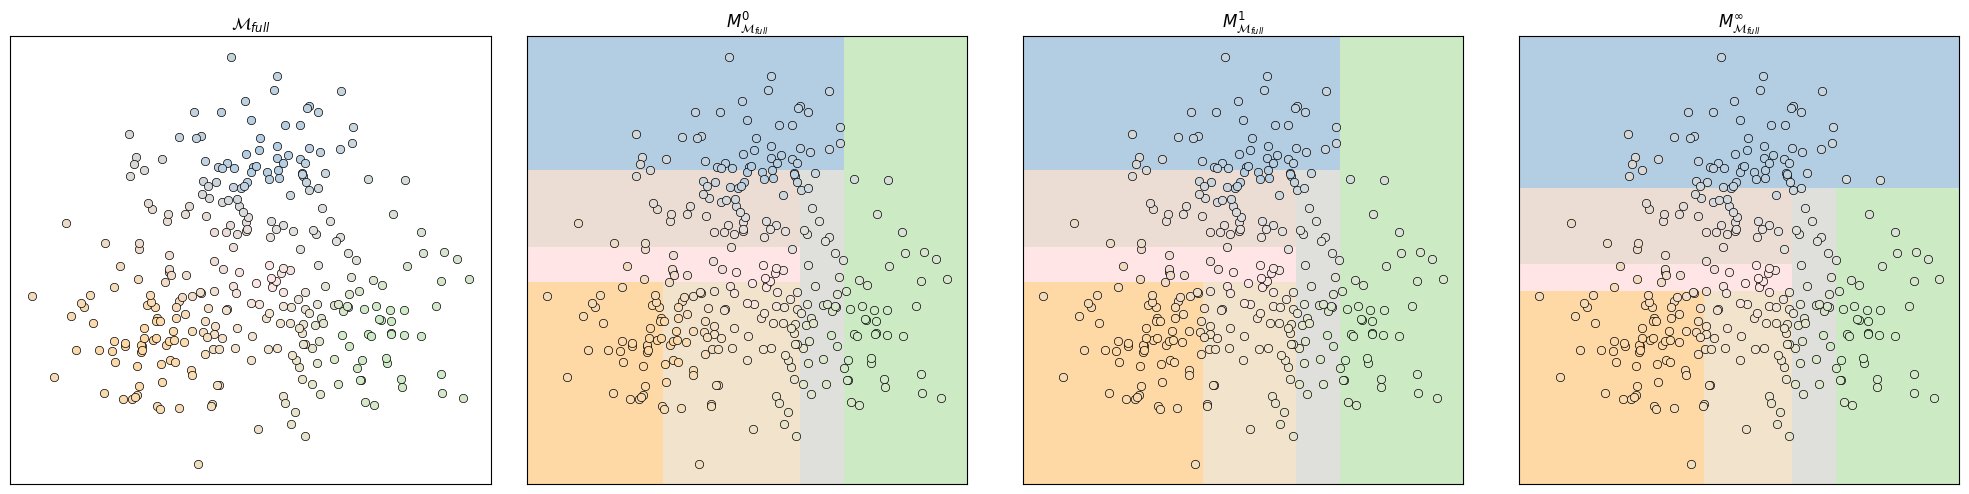

In [261]:
full_model = ecm(x=features, c=number_clusters, alpha=0.5, beta = 1.8, delta=10, disp=False, type='full')
full_outs = plot_model(full_model['mass_n'], full_model['F'][1:], 'full', lambda_num=1)

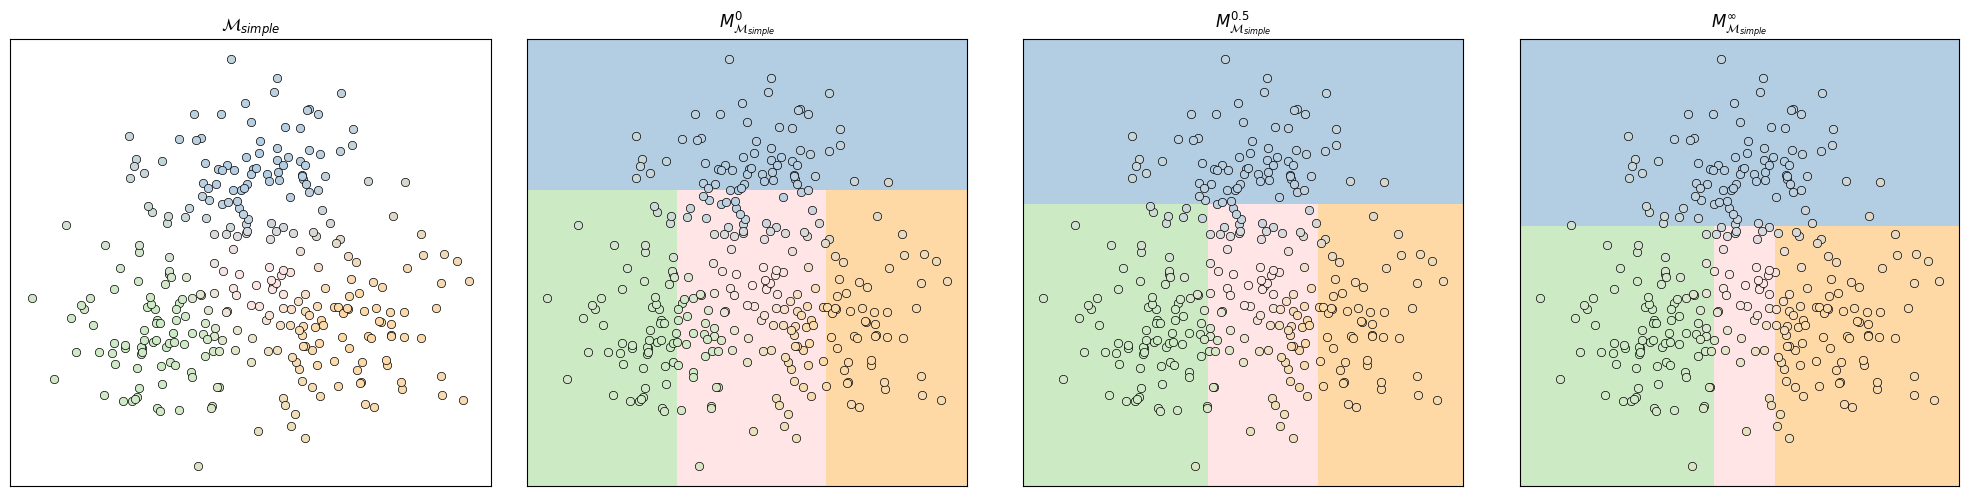

In [262]:
simple_model = ecm(x=features, c=number_clusters, alpha=0.5, beta = 1.8, delta=10, disp=False, type='simple')
simple_outs = plot_model(simple_model['mass_n'], simple_model['F'][1:], 'simple', lambda_num=0.5)

/Users/victor/Documents/GitHub/xedt/.venv/lib/python3.9/site-packages/evclust/ecm.py:121: RuntimeWarning: overflow encountered in power
  vect1 = (np.tile(D[i, j], f-1) / vect0) ** (1 / (beta-1))
/Users/victor/Documents/GitHub/xedt/.venv/lib/python3.9/site-packages/evclust/ecm.py:123: RuntimeWarning: overflow encountered in multiply
  vect3 = vect1 * vect2


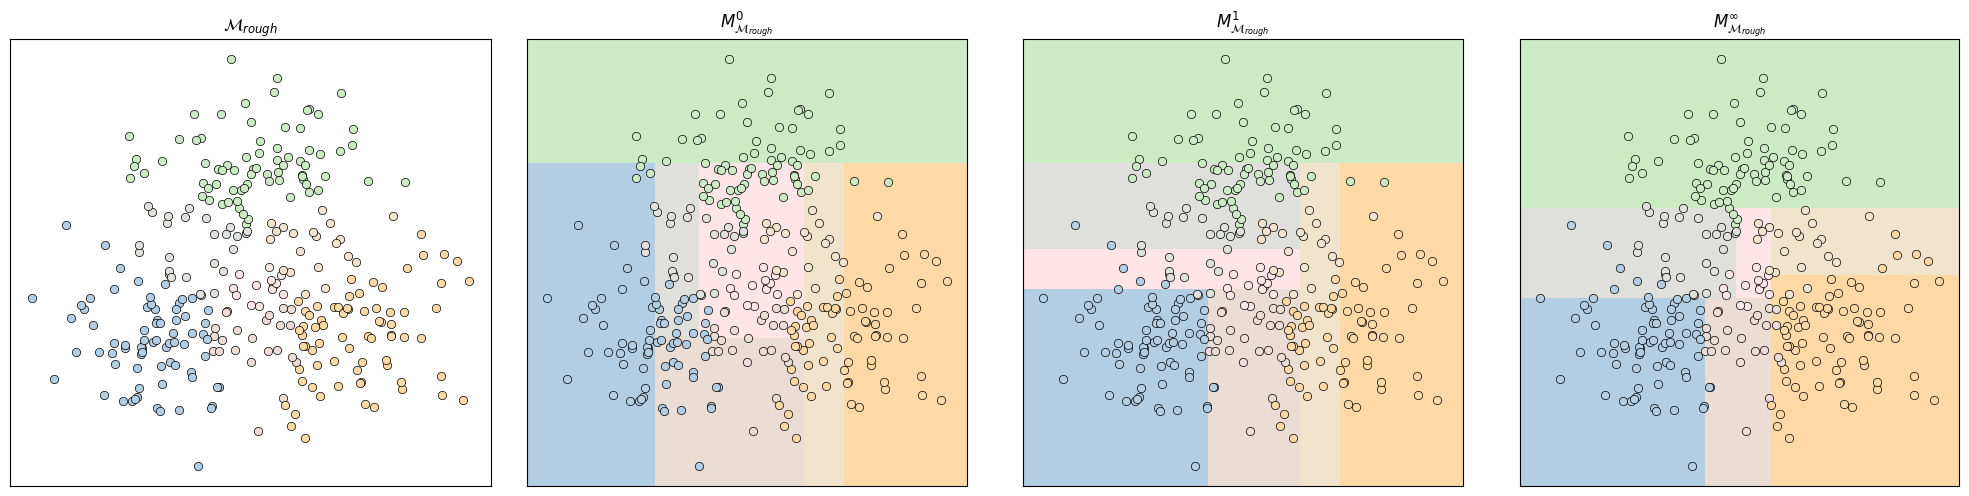

In [263]:
rough_model = ecm(x=features, c=number_clusters, alpha=1, beta = 1.01, delta=10, disp=False, type='full')
rough_outs = plot_model(np.round(rough_model['mass_n']), rough_model['F'][1:], 'rough', lambda_num=1)